In [357]:
import numpy as np
import pandas as pd
from sklearn.metrics import explained_variance_score
from parameters import Parameters
from methods import Methods
from functions import *
from errors import *
from random import random

In [358]:
np.seterr(all='ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [359]:
# load dataset
df = pd.read_csv('btc_usd.csv')
df.head()
# df = df.to_numpy()
# X = df[:, [i for i in range(10)]]
# y = df[:, 10]

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [360]:
df['Date'] = pd.to_datetime(df['Date'])
df['PastWeekOpen'] = df['Open'].shift(1)
df['PastWeekHigh'] = df['High'].shift(0)
df['PastWeekLow'] = df['Low'].shift(0)
# df = df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])
df = df.drop(columns=['Open', 'High', 'Low', 'Adj Close'])
df.head()

,Date,Close,Volume,PastWeekOpen,PastWeekHigh,PastWeekLow
0,2014-09-17,457.334015,21056800,NaN,468.174011,452.421997
1,2014-09-18,424.440002,34483200,465.864014,456.859985,413.104004
2,2014-09-19,394.795990,37919700,456.859985,427.834991,384.532013
3,2014-09-20,408.903992,36863600,424.102997,423.295990,389.882996
4,2014-09-21,398.821014,26580100,394.673004,412.425995,393.181000


In [361]:
train_mask = (df['Date'] >= '2021-6-1') & (df['Date'] <= '2021-12-31')
train_df = df.loc[train_mask]
train_df.head()

,Date,Close,Volume,PastWeekOpen,PastWeekHigh,PastWeekLow
2449,2021-06-01,36684.925781,34639423297,35658.593750,37896.734375,35787.085938
2450,2021-06-02,37575.179688,33070867190,37293.792969,38231.339844,35966.308594
2451,2021-06-03,39208.765625,35460750427,36699.921875,39478.953125,37243.972656
2452,2021-06-04,36894.406250,41831090187,37599.410156,39242.484375,35717.722656
2453,2021-06-05,35551.957031,35959473399,39242.484375,37917.714844,34900.414063


In [362]:
test_mask = (df['Date'] >= '2022-1-1') & (df['Date'] <= '2022-2-19')
test_df = df.loc[test_mask]
test_df.head()

,Date,Close,Volume,PastWeekOpen,PastWeekHigh,PastWeekLow
2663,2022-01-01,47686.812500,24582667004,47169.371094,47827.312500,46288.484375
2664,2022-01-02,47345.218750,27951569547,46311.746094,47881.406250,46856.937500
2665,2022-01-03,46458.117188,33071628362,47680.925781,47510.726563,45835.964844
2666,2022-01-04,45897.574219,42494677905,47343.542969,47406.546875,45752.464844
2667,2022-01-05,43569.003906,36851084859,46458.851563,46929.046875,42798.222656


In [363]:
X_train = train_df[['PastWeekOpen', 'PastWeekHigh', 'PastWeekLow']]
# X_train = train_df[['PastWeekHigh', 'PastWeekLow', 'Volume']]
y_train = train_df['Close']
date_train = train_df['Date']
X_test = test_df[['PastWeekOpen', 'PastWeekHigh', 'PastWeekLow']]
# X_test = test_df[['PastWeekHigh', 'PastWeekLow', 'Volume']]
y_test = test_df['Close']
date_test = test_df['Date']

In [364]:
# X_train.head()
# y_train.head()
# X_test.head()
y_test.head()

2663    47686.812500
2664    47345.218750
2665    46458.117188
2666    45897.574219
2667    43569.003906
Name: Close, dtype: float64

In [365]:
# convert to numpy objects
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [366]:
Parameters.CONSTANTS = [-5, 5]
# Parameters.CONSTANTS = [1, 10]
Parameters.FEATURES = X_train.shape[1]
Parameters.CONSTANTS_TYPE = 'range'
# Parameters.CONSTANTS_TYPE = 'integer'
# expressions = [Add, Sub, Mul, Div, Sin, Cos, Rlog, Exp, Pow]
expressions = [Add, Sub, Mul, Div]
terminals = [Variable, Constant]

In [367]:
from fp import FP
model = FP(pop_size=50,
        alpha=0.1,
        beta=0.5,
        gamma=1.0,
        max_evaluations=25000,
        initial_min_depth=0,
        initial_max_depth=6,
        max_depth=15,
        error_function=RMSE,
        expressions=expressions,
        terminals=terminals,
        target_error=0,
        verbose=True
        )

model.fit(X_train, y_train)

Evaluations: 37 | Fitness: 48110.26155735325
Evaluations: 38 | Fitness: 48109.320627270856
Evaluations: 39 | Fitness: 48101.43080942751
Evaluations: 41 | Fitness: 2413.2957832537404
Evaluations: 43 | Fitness: 1732.5690415473066
Evaluations: 44 | Fitness: 1601.6814288947587
Evaluations: 100 | Fitness: 1598.309075102378
Evaluations: 489 | Fitness: 1598.2514027981626
Evaluations: 749 | Fitness: 1597.0672231808642
Evaluations: 812 | Fitness: 1594.9432072295008
Evaluations: 851 | Fitness: 1591.5838664252278
Evaluations: 880 | Fitness: 1590.4956780842808
Evaluations: 941 | Fitness: 1588.5350026839417
Evaluations: 942 | Fitness: 1581.8481238315017
Evaluations: 1036 | Fitness: 1581.5454219419669
Evaluations: 1057 | Fitness: 1578.2126062801933
Evaluations: 1439 | Fitness: 1574.886527475072
Evaluations: 1487 | Fitness: 1271.1952461567573
Evaluations: 2279 | Fitness: 1270.9859670049605
Evaluations: 2315 | Fitness: 1270.7187218350714
Evaluations: 2927 | Fitness: 1269.3401123486356
Evaluations: 308

In [368]:
y_fit = model.predict(X_train)
y_pred = model.predict(X_test)
train_score = explained_variance_score(y_train, y_fit)
test_score = explained_variance_score(y_test, y_pred)
print('Train score: {}'.format(train_score))
print('Test score: {}'.format(test_score))

Train score: 0.9895429908821478
Test score: 0.9148913932820757


Populating the interactive namespace from numpy and matplotlib


C:\Users\Aliwi\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['uniform', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


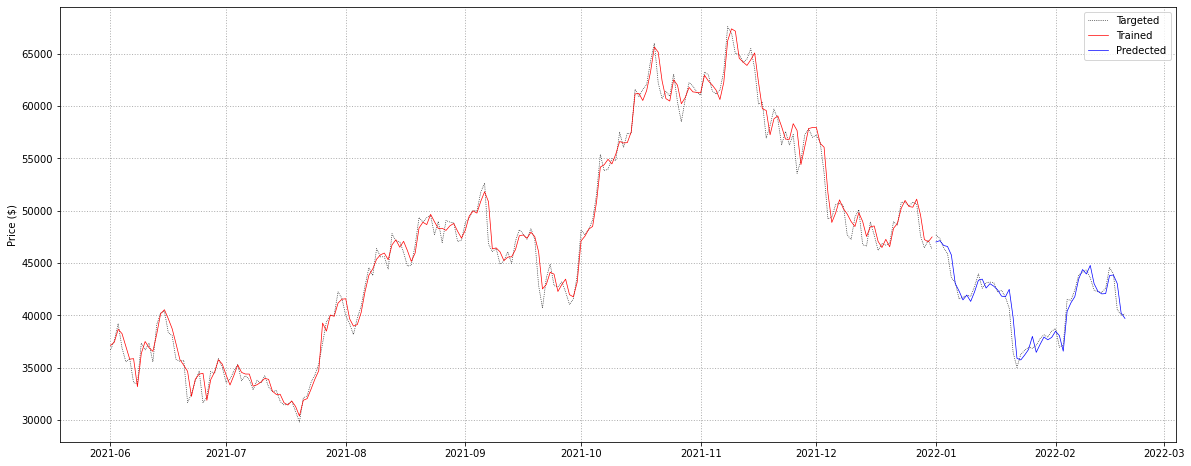

In [369]:
%pylab inline
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = (20, 8)
ax = plt.axes()
ax.grid(linestyle=':', linewidth=1, alpha=1, zorder=1)
plt.ylabel("Price ($)")
line = [None, None, None, None]
line[0], = ax.plot(date_train, y_train, linestyle=':', color='black', linewidth=0.7, zorder=2, label='Targeted')    
line[1], = ax.plot(date_train, y_fit, linestyle='-', color='red', linewidth=0.7, zorder=3, label='Trained')
line[2], = ax.plot(date_test, y_test, linestyle=':', color='black', linewidth=0.7, zorder=2)
line[3], = ax.plot(date_test, y_pred, linestyle='-', color='blue', linewidth=0.7, zorder=3, label='Predected')
plt.draw()
plt.legend()
plt.show()

In [370]:
from dfp import DFP
dfp_model = DFP(pop_size=50,
        alpha=1800,
        beta=1500,
        gamma=1250,
        max_evaluations=25000,
        initial_min_depth=0,
        initial_max_depth=6,
        max_depth=15,
        error_function=RMSE,
        expressions=expressions,
        terminals=terminals,
        target_error=0,
        verbose=True
        )

dfp_model.fit(X_train, y_train)

Evaluations: 80 | Fitness: 30110.665802369826
Evaluations: 81 | Fitness: 1597.4631315828076
Evaluations: 479 | Fitness: 1596.5352433599135
Evaluations: 2789 | Fitness: 1592.1493815784058
Evaluations: 3897 | Fitness: 1576.550803330562
Evaluations: 9140 | Fitness: 1560.7131164235243
Evaluations: 23212 | Fitness: 1553.4627747211764
(((((x1)+(-4.750514177082298))/(x2))/((x0)+(-3.3801125061382873)))-(((2.722641945249422)/(-0.778141005210248))*((-4.909355150503121)*(4.69697352242482))))


In [371]:
dfp_y_fit = dfp_model.predict(X_train)
dfp_y_pred = dfp_model.predict(X_test)
dfp_train_score = explained_variance_score(y_train, dfp_y_fit)
dfp_test_score = explained_variance_score(y_test, dfp_y_pred)
print('Train score: {}'.format(dfp_train_score))
print('Test score: {}'.format(dfp_test_score))

Train score: 0.9873233267291128
Test score: 0.8958401062221177


In [372]:
# example of calculate the mean squared error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_poisson_deviance

print('Train RMSE: ', mean_squared_error(y_train, dfp_y_fit, squared=False) )
print('Train R2: ', r2_score(y_train, dfp_y_fit) )

print('Test RMSE: ', mean_squared_error(y_test, dfp_y_pred, squared=False) )
print('Test R2: ', r2_score(y_test, dfp_y_pred) )


RMSE:  1553.4627747211764
R2:  0.9749121806323344
RMSE:  1275.0052819752673
R2:  0.8247743635104896


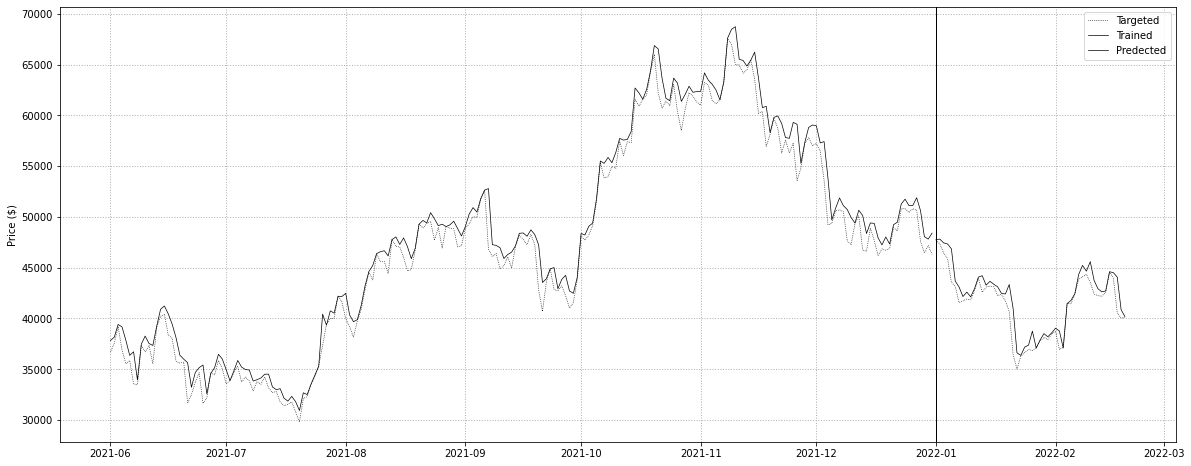

In [377]:
ax = plt.axes()
ax.grid(linestyle=':', linewidth=1, alpha=1, zorder=1)
plt.ylabel("Price ($)")
line = [None, None, None, None]
line[0], = ax.plot(date_train, y_train, linestyle=':', color='black', linewidth=0.7, zorder=2, label='Targeted')    
line[1], = ax.plot(date_train, dfp_y_fit, linestyle='-', color='black', linewidth=0.7, zorder=3, label='Trained')
line[2], = ax.plot(date_test, y_test, linestyle=':', color='black', linewidth=0.7, zorder=2)
line[3], = ax.plot(date_test, dfp_y_pred, linestyle='-', color='black', linewidth=0.7, zorder=3, label='Predected')
plt.axvline(x=date_test.iloc[0], linestyle='-', color='black', linewidth='1')
plt.draw()
plt.legend()
plt.show()